# TEDx

In [208]:
import os
import pandas as pd
import docx
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import unidecode
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

Create db

In [209]:
def get_text(filename):
    doc = docx.Document(filename)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

In [210]:
df = pd.DataFrame(columns=['file', 'text'])

In [211]:
for filename in os.listdir(directory):
    if filename.startswith("Copy of "):
        os.rename('data/' + filename, 'data/' + filename[8:])

In [212]:
directory = 'data/'
for filename in os.listdir(directory):
    if filename.endswith(".docx"): 
        print("docx!")
        print(os.path.join(directory, filename))
        text = get_text('data/' + filename)
    elif filename.endswith('.txt'):
        # print("txt!")
        # print(os.path.join(directory, filename)) 
        with open('data/' + filename, 'r') as f:
            text = f.read()
    else:
        continue
    
    data = pd.DataFrame({"file": [filename], "text": [text]})
    df = df.append(data, ignore_index=True)


docx!
data/[Pepe Menendez]-Gastón Falanga.docx
docx!
data/5 Gloria Vidal.docx
docx!
data/GeronimoVillanueva-DanielaGarufi.docx
docx!
data/1 Andrea Casamento final.docx
docx!
data/VictoriaFlexer-DanielaGarufi.docx
docx!
data/[Melina Furman]-Viviana Daniel.docx
docx!
data/[Julieta Lanteri]-Gastón Falanga.docx
docx!
data/[Nadia Chiaramoni]-Viviana Daniel.docx
docx!
data/[Demian Reidel]-Viviana Daniel.docx
docx!
data/[Juan Pablo Sorín]-Gastón Falanga.docx
docx!
data/[Magdalena Fleitas]-Gastón Falanga.docx
docx!
data/[Diego Slezak]-Gastón Falanga.docx
docx!
data/[Diego Gutnisky]-Viviana Daniel.docx
docx!
data/[ArTED]-Viviana Daniel.docx
docx!
data/[Jorge Drexler]-Gastón Falanga.docx
docx!
data/JoséNesis-DanielaGarufi.docx
docx!
data/TeresaBo-DanielaGarufi.docx
docx!
data/[Lucho Mellera]-Gastón Falanga.docx
docx!
data/[Julián Garbulsky]-Viviana Daniel.docx
docx!
data/[Radagast]-Viviana Daniel.docx
docx!
data/[Pablo Marchetti]-Gastón Falanga.docx
docx!
data/ConstanzaOrbaiz-DanielaGarufi.docx

Clean db

In [213]:
df.sample(5)

,file,text
24,[Georgina Orellano]-Viviana Daniel.docx,\n(Aplausos)\nTenía 25 años y necesitaba volve...
5,Una historia de amor Osvaldo Natucci TEDxRío...,"En 1914,\n\ndos miembros de la realeza italian..."
22,[Pablo Marchetti]-Gastón Falanga.docx,Buenas tardes. \nLa concha de su madre. \n(Apl...
21,[Radagast]-Viviana Daniel.docx,\n¿Cómo están? ¿Todo bien? (Gritos) ¡Gracias! ...
7,[Melina Furman]-Viviana Daniel.docx,\n-¿Cómo hacen las lombrices para respirar aba...


In [214]:
df['text'] = df['text'].str.replace("\n", ' ')
df['words'] = df.text.str.strip().str.split('[\W_]+')
rows = list()
for row in df[['words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((word))

words = pd.DataFrame(rows, columns=['word'])
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
counts = words.word.value_counts().to_frame().rename(columns={'word':'count_per_word'})

stopwords = stopwords.words('spanish')
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)
        
drop_list = ['aplausos', 'si']
for a_word in counts.index:
    if unidecode.unidecode(a_word) in stopwords:
        drop_list.append(a_word)

counts = counts.drop(drop_list)
top_20 = counts.head(20)

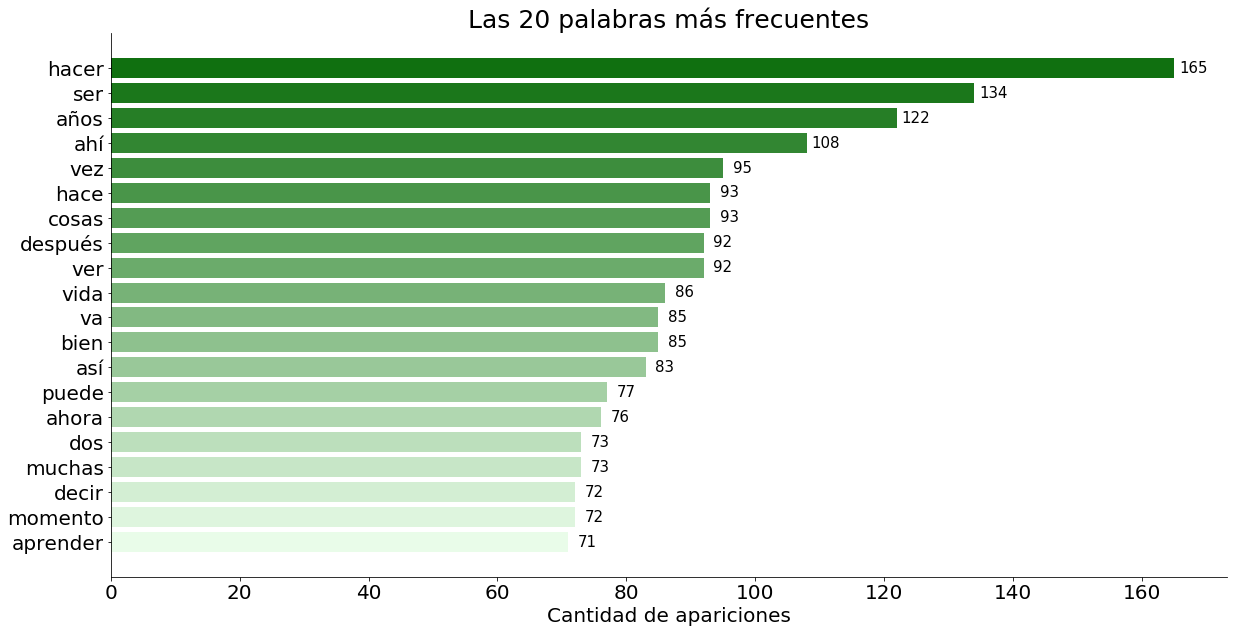

In [215]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="count_per_word", y=top_20.index, data=top_20, palette=sns.light_palette("green", n_colors=20, reverse=True))
plt.ylabel("")
plt.xlabel('Cantidad de apariciones', fontsize=20)
plt.title('Las 20 palabras más frecuentes', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3  ,
            p.get_y() + p.get_height()/1.4,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

In [216]:
head = counts.head(200)
to_plot = list(zip(head.index, head['count_per_word']))

In [217]:
def plot_wordcloud_from_list(a_list, title=None):
    if not title:
        title = "img_%d.jpg" % math.random.uniform(1, 12321)
    freqs_by_words = {}
    for a_topic_term in a_list:
        an_actual_word = a_topic_term[0]
        freqs_by_words[an_actual_word] = a_topic_term[1]

    wc = WordCloud(background_color="white", max_words=2000, max_font_size=100,)
    # generate word cloud
    wc.generate_from_frequencies(freqs_by_words)

    #show
    plt.figure(figsize=(15,10))
    plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()


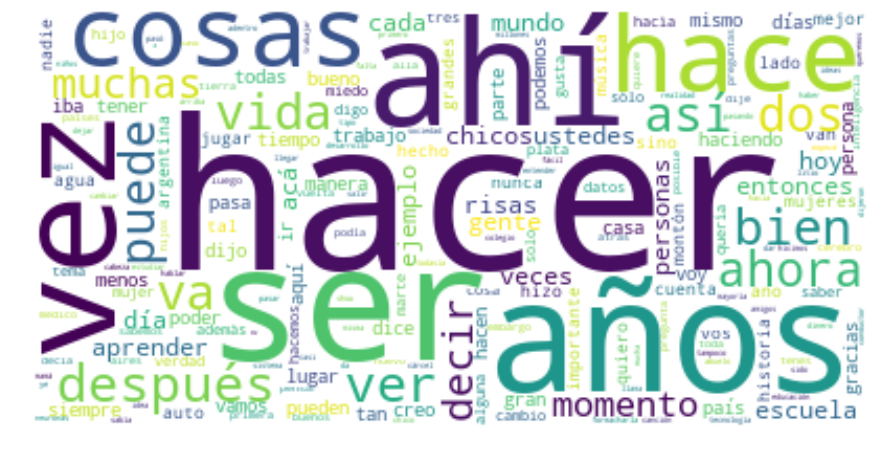

In [218]:
plot_wordcloud_from_list(to_plot, "wordcloud")

In [219]:
stopset = set(stopwords + drop_list)
TED_TALK_DURATION = 20 * 60 # SECONDS. (20 min each ted talk)
df['tokens'] = pd.Series(dtype=object)
for index, row in df.iterrows():
    tokens = word_tokenize(row['text'])
    tokens_wo_stopwords = [word for word in tokens if not word in stopset]
    df.at[index, 'tokens'] = tokens_wo_stopwords
    df.at[index, 'le_d'] = ( len(tokens_wo_stopwords) / len(tokens) ) * 100
    df.at[index, 'ly_d'] = len(tokens) / TED_TALK_DURATION
    df.at[index, 'n_words'] = len(tokens)
    df.at[index, 'n_words_no_rep'] = len(list(set(tokens)))


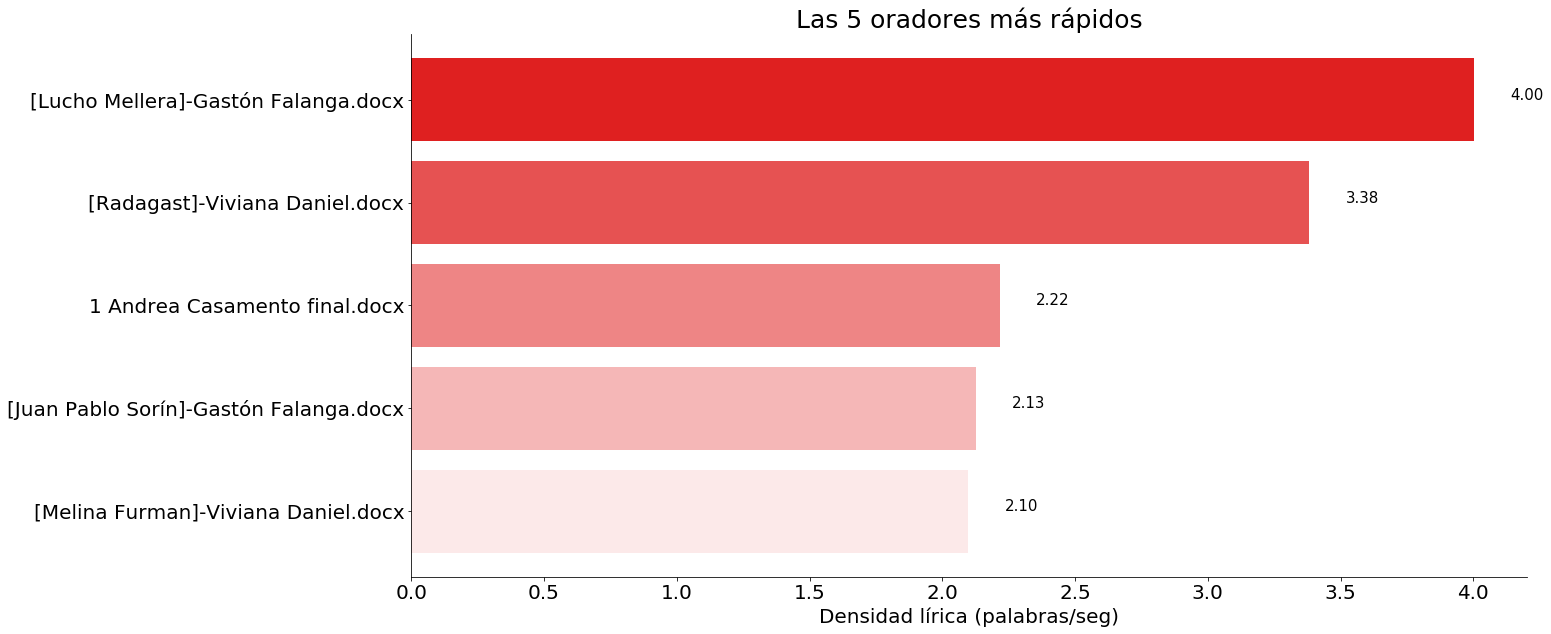

In [258]:
faster_speakers = df.sort_values("ly_d", ascending=False)[:5]


fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="ly_d", y='file', data=faster_speakers, palette=sns.light_palette("red", n_colors=5, reverse=True))
plt.ylabel("")
plt.xlabel('Densidad lírica (palabras/seg)', fontsize=20)
plt.title('Las 5 oradores más rápidos', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + .2  ,
            p.get_y() + p.get_height()/2.,
            "%.02f" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

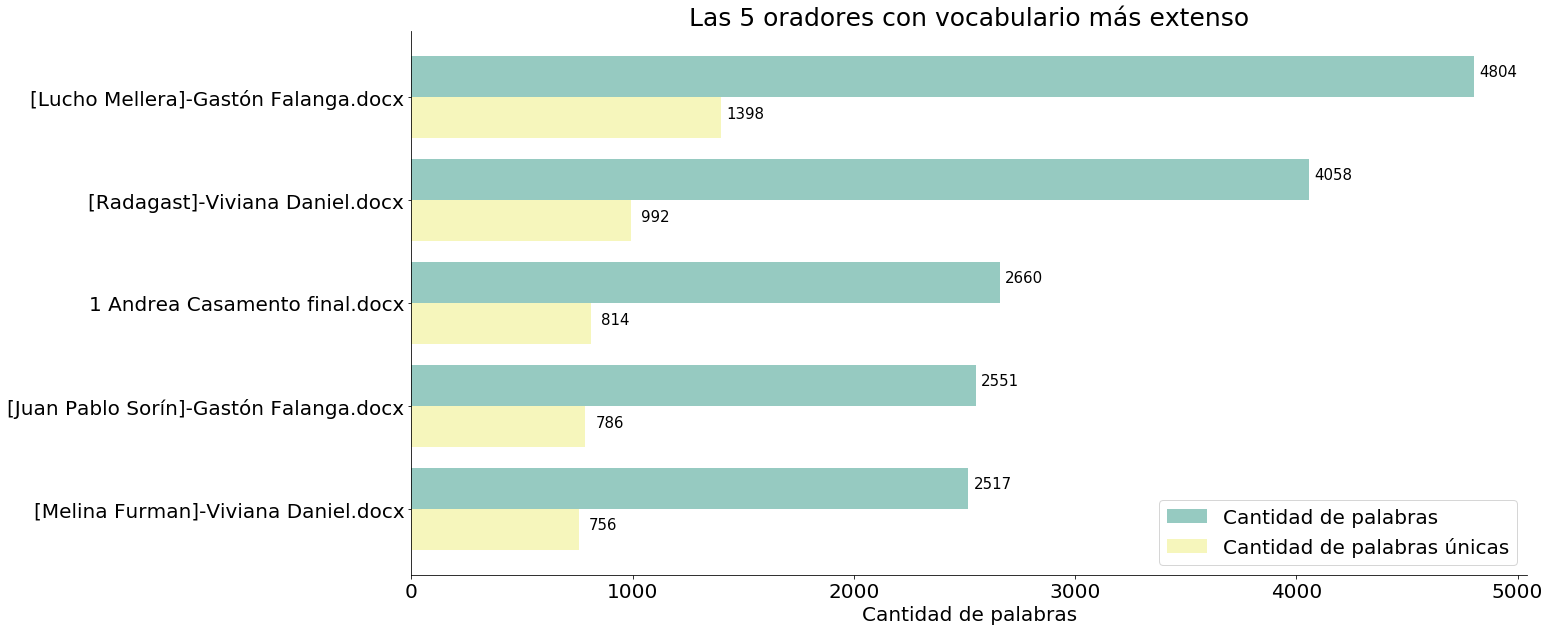

In [257]:
more_vocab = df.sort_values("n_words", ascending=False)[:5]
more_vocab = more_vocab[['file', 'n_words', 'n_words_no_rep']]
more_vocab.columns = ['file', 'Cantidad de palabras', 'Cantidad de palabras únicas']

more_vocab = (
    more_vocab.set_index('file')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)



fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="Value", y='file', hue='Variable', data=more_vocab, palette="Set3")
plt.ylabel("")
plt.xlabel('Cantidad de palabras', fontsize=20)
plt.title('Las 5 oradores con vocabulario más extenso', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 110  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
ax.legend(prop={'size': 20})

sns.despine()
plt.plot();